This program is free software: you can redistribute it and/or modify it under the terms of the GNU General Public License as published by the Free Software Foundation, either version 3 of the License, or (at your option) any later version.

This program is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU General Public License for more details.

You should have received a copy of the GNU General Public License along with this program. If not, see <https://www.gnu.org/licenses/>. 

In [1]:
using DrWatson
@quickactivate "FastDysonSolver"

In [2]:
using Revise
using BenchmarkTools
includet("../src/BlasSelector.jl")
includet("../src/AdaptativeSampler.jl")

In [3]:
@show Threads.nthreads()
@show Threads.ngcthreads()

Threads.nthreads() = 20
Threads.ngcthreads() = 20


20

In [4]:
using LinearAlgebra
select_BLAS()
using HssMatrices
using NonEquilibriumGreenFunction

using GLMakie
using Colors
using ColorSchemes
using LaTeXStrings

using Symbolics
using SymbolicNumericIntegration
using DSP

Intel CPU detected


In [5]:
includet("./../src/Junction.jl")

In [6]:
function setup_figure()
    prl_width = 3.38583
    size = 170 .* (prl_width, 1 * prl_width)
    return Figure(size=size, fontsize=18)
end

setup_figure (generic function with 1 method)

In [7]:
using Parameters
@with_kw struct ProblemParameters
    V_start::Float64 = 0
    V_end::Float64
    Γ::Float64 
    t_start::Float64
    t_end::Float64
    Γl::Float64 = 1.0
    Γr::Float64 = 1.0
    δt::Float64
    ϕ_switch::Float64 = 0.0
    β::Float64 = 100
end
get_β(p::ProblemParameters) = 1000.0
axis(p::ProblemParameters) = 0:p.δt:p.t_start + p.t_end

axis (generic function with 2 methods)

In [8]:
function get_junction_for_thermal(pp::ProblemParameters)
    return  p_th = JunctionParameters(; δt=pp.δt, T=pp.t_start + pp.t_end, Γl=pp.Γl, Γr=pp.Γr, ϕl=t->pp.ϕ_switch / 2, ϕr=t-> -pp.ϕ_switch / 2 , β=pp.β)
end
function get_thermal_green_functions(pp::ProblemParameters)
    p_th = get_junction_for_thermal(pp)
    result = simulate_thermal_equilibrium_junction(p_th)
    return result
end

function phase_difference(V, t0)
    @variables tau, t
    expr = integrate(2 * V(tau), (tau, t0, t), detailed=false, symbolic=true)
    δϕ = build_function(expr, t, expression=Val{false})
    return δϕ
end
function phase_difference(V0, t_start, V1, t_end, ϕ_switch)
    δϕ_start = phase_difference(V0, 0)
    δϕ_end = phase_difference(V1, t_start)
    δϕ(t) = t < t_start ? δϕ_start(t) - δϕ_start(t_start) + ϕ_switch : ϕ_switch + δϕ_end(t)
    return δϕ
end
function phase_difference(pp::ProblemParameters)
    V0(t) = pp.V_start
    V1(t) = pp.V_end
    return phase_difference(V0, pp.t_start, V1, pp.t_end, pp.ϕ_switch)
end
function simulate_junction_with_voltage_switch(pp::ProblemParameters)
    thermal_data = get_thermal_green_functions(pp)

    ϕ = phase_difference(pp)
    ϕl(t) = ϕ(t) / 2
    ϕr(t) = -ϕ(t) / 2

    g_R_lead = thermal_data[:g_R_lead]
    # equilibrium couplings from the precomputed thermal data
    coupling_left_equilibrium = thermal_data[:coupling_left]
    coupling_right_equilibrium = thermal_data[:coupling_right]

    # time-dependent full couplings for the switched junction
    coupling_left_time_dependent_full = discretize_dirac(
        axis(pp),
        t -> sqrt(pp.Γl / pi) * exp(1im * σz() * ϕl(t) / 2) * σz(),
        compression=default_compression()
    )
    coupling_right_time_dependent_full = discretize_dirac(
        axis(pp),
        t -> sqrt(pp.Γr / pi) * exp(1im * σz() * ϕr(t) / 2) * σz(),
        compression=default_compression()
    )

    # non-equilibrium (difference) couplings used in the dynamics
    coupling_left_non_equilibrium = coupling_left_time_dependent_full - coupling_left_equilibrium
    coupling_right_non_equilibrium = coupling_right_time_dependent_full - coupling_right_equilibrium

    # aliases to match names used later in the function
    coupling_left = coupling_left_non_equilibrium
    coupling_right = coupling_right_non_equilibrium

    Σ_R_left = coupling_left' * g_R_lead * coupling_left
    Σ_R_right = coupling_right' * g_R_lead * coupling_right
    Σ_R = Σ_R_left + Σ_R_right
    G_R = solve_dyson(thermal_data[:G_R], thermal_data[:G_R] * Σ_R)

    ρ = discretize_acausalkernel(axis(pp), (t, tp) -> thermal_kernel(t - tp, get_β(pp)) * σ0() .|> ComplexF64, stationary=true, compression=default_compression())
    g_lead_kinetic = g_R_lead * ρ - ρ * g_R_lead'

    Σ_K_left = compress!(coupling_left' * g_lead_kinetic * coupling_left)
    Σ_K_right = compress!(coupling_right' * g_lead_kinetic * coupling_right)
    Σ_K = Σ_K_left + Σ_K_right
    _op = Threads.@spawn (I + G_R * Σ_R)
    _GR_Σ_K_GR_adjoint = Threads.@spawn(G_R*Σ_K*G_R')
    op = fetch(_op)
    correction = op*thermal_data[:G_K]*op'
    G_K = compress!(fetch(_GR_Σ_K_GR_adjoint) + correction)
    return (;G_R_stat = thermal_data[:G_R], G_K_stat = thermal_data[:G_K], Σ_R_left, G_R, G_K, Σ_K_right, Σ_R_right, ϕ,
        Σ_R_right_stat=thermal_data[:Σ_R_right], Σ_K_right_stat=thermal_data[:Σ_K_right])
end
function compute_average_current(full_GR, full_GK, Σ_R_left, Σ_K_left)
    #First we build the expression
    function f(G_R, G_K, Σ_R, Σ_K)
        _Σ_R_time_G_R = Threads.@spawn Σ_R * G_R
        _G_R_time_Σ_R = Threads.@spawn G_R * Σ_R
        _G_R_time_Σ_K = Threads.@spawn G_R * Σ_K
        _G_K_time_adjoint_Σ_R = Threads.@spawn G_K * adjoint(Σ_R)
        _Σ_K_time_adjoint_G_R = Threads.@spawn Σ_K * adjoint(G_R)
        _Σ_R_time_G_K = Threads.@spawn Σ_R * G_K

        Σ_R_time_G_R = fetch(_Σ_R_time_G_R)
        G_R_time_Σ_R = fetch(_G_R_time_Σ_R)
        G_R_time_Σ_K = fetch(_G_R_time_Σ_K)
        G_K_time_adjoint_Σ_R = fetch(_G_K_time_adjoint_Σ_R)
        Σ_K_time_adjoint_G_R = fetch(_Σ_K_time_adjoint_G_R)
        Σ_R_time_G_K = fetch(_Σ_R_time_G_K)

        return -((1 // 2) * ((adjoint(Σ_R_time_G_R)) - Σ_R_time_G_R) + G_R_time_Σ_K + G_K_time_adjoint_Σ_R + -(Σ_K_time_adjoint_G_R + Σ_R_time_G_K) + (3 // 2) * (G_R_time_Σ_R - adjoint(G_R_time_Σ_R)))
    end
    I_avr_op = f(full_GR, full_GK, Σ_R_left, Σ_K_left)
    #We have to take the trace on the Keldysh space by hand. 
    dg = diag(matrix(I_avr_op))
    (dg[1:2:end] .- dg[2:2:end])
end

function compute_current_thermal(pp::ProblemParameters)
    result = simulate_junction_with_voltage_switch(pp)
    I_junction = compute_average_current(result[:G_R_stat],
    result[:G_K_stat],
    result[:Σ_R_right_stat],
    result[:Σ_K_right_stat]
    )
    return (; p = pp, Ij = real.(I_junction) )
end
function compute_current(pp::ProblemParameters)
    result = simulate_junction_with_voltage_switch(pp)
    I_junction = compute_average_current(result[:G_R],
    result[:G_K],
    result[:Σ_R_right] + result[:Σ_R_right_stat],
    result[:Σ_K_right] + result[:Σ_K_right_stat]
    )
    return (; p = pp, Ij = real.(I_junction) )
end

compute_current (generic function with 1 method)

In [9]:
ϕ_switch = 0.8*pi
Γ = 1
δt = 0.1
t_start = 400
t_end = 400
V = 0.8
β = 100
_I_junction_switch_off = Threads.@spawn compute_current(ProblemParameters(
    V_start=V,
    V_end=0,
    Γ=Γ,
    t_start=t_start,
    t_end=t_end,
    δt=δt,
    ϕ_switch = ϕ_switch,
    β = β
));
I_junction_switch_on = compute_current(ProblemParameters(
    V_start=0,
    V_end=V,
    Γ=Γ,
    t_start=t_start,
    t_end=t_end,
    δt=δt,
    ϕ_switch = ϕ_switch,
    β = β
));
I_junction_switch_off = fetch(_I_junction_switch_off)

(p = ProblemParameters
  V_start: Float64 0.8
  V_end: Float64 0.0
  Γ: Float64 1.0
  t_start: Float64 400.0
  t_end: Float64 400.0
  Γl: Float64 1.0
  Γr: Float64 1.0
  δt: Float64 0.1
  ϕ_switch: Float64 2.5132741228718345
  β: Float64 100.0
, Ij = [-8.596992125555917e-17, 0.08724084519487334, 0.12121052281058445, 0.13870420268482775, 0.15114068843534148, 0.1617936269158201, 0.17143044215588138, 0.18010197483201962, 0.18769224005391466, 0.19407644744321143  …  0.4442363047143152, 0.44468148800544793, 0.44516959919646676, 0.44569262436303825, 0.44624221124123753, 0.44680977241997044, 0.44738658751877175, 0.44796390632143734, 0.4485330555566509, 0.44908555223155155])

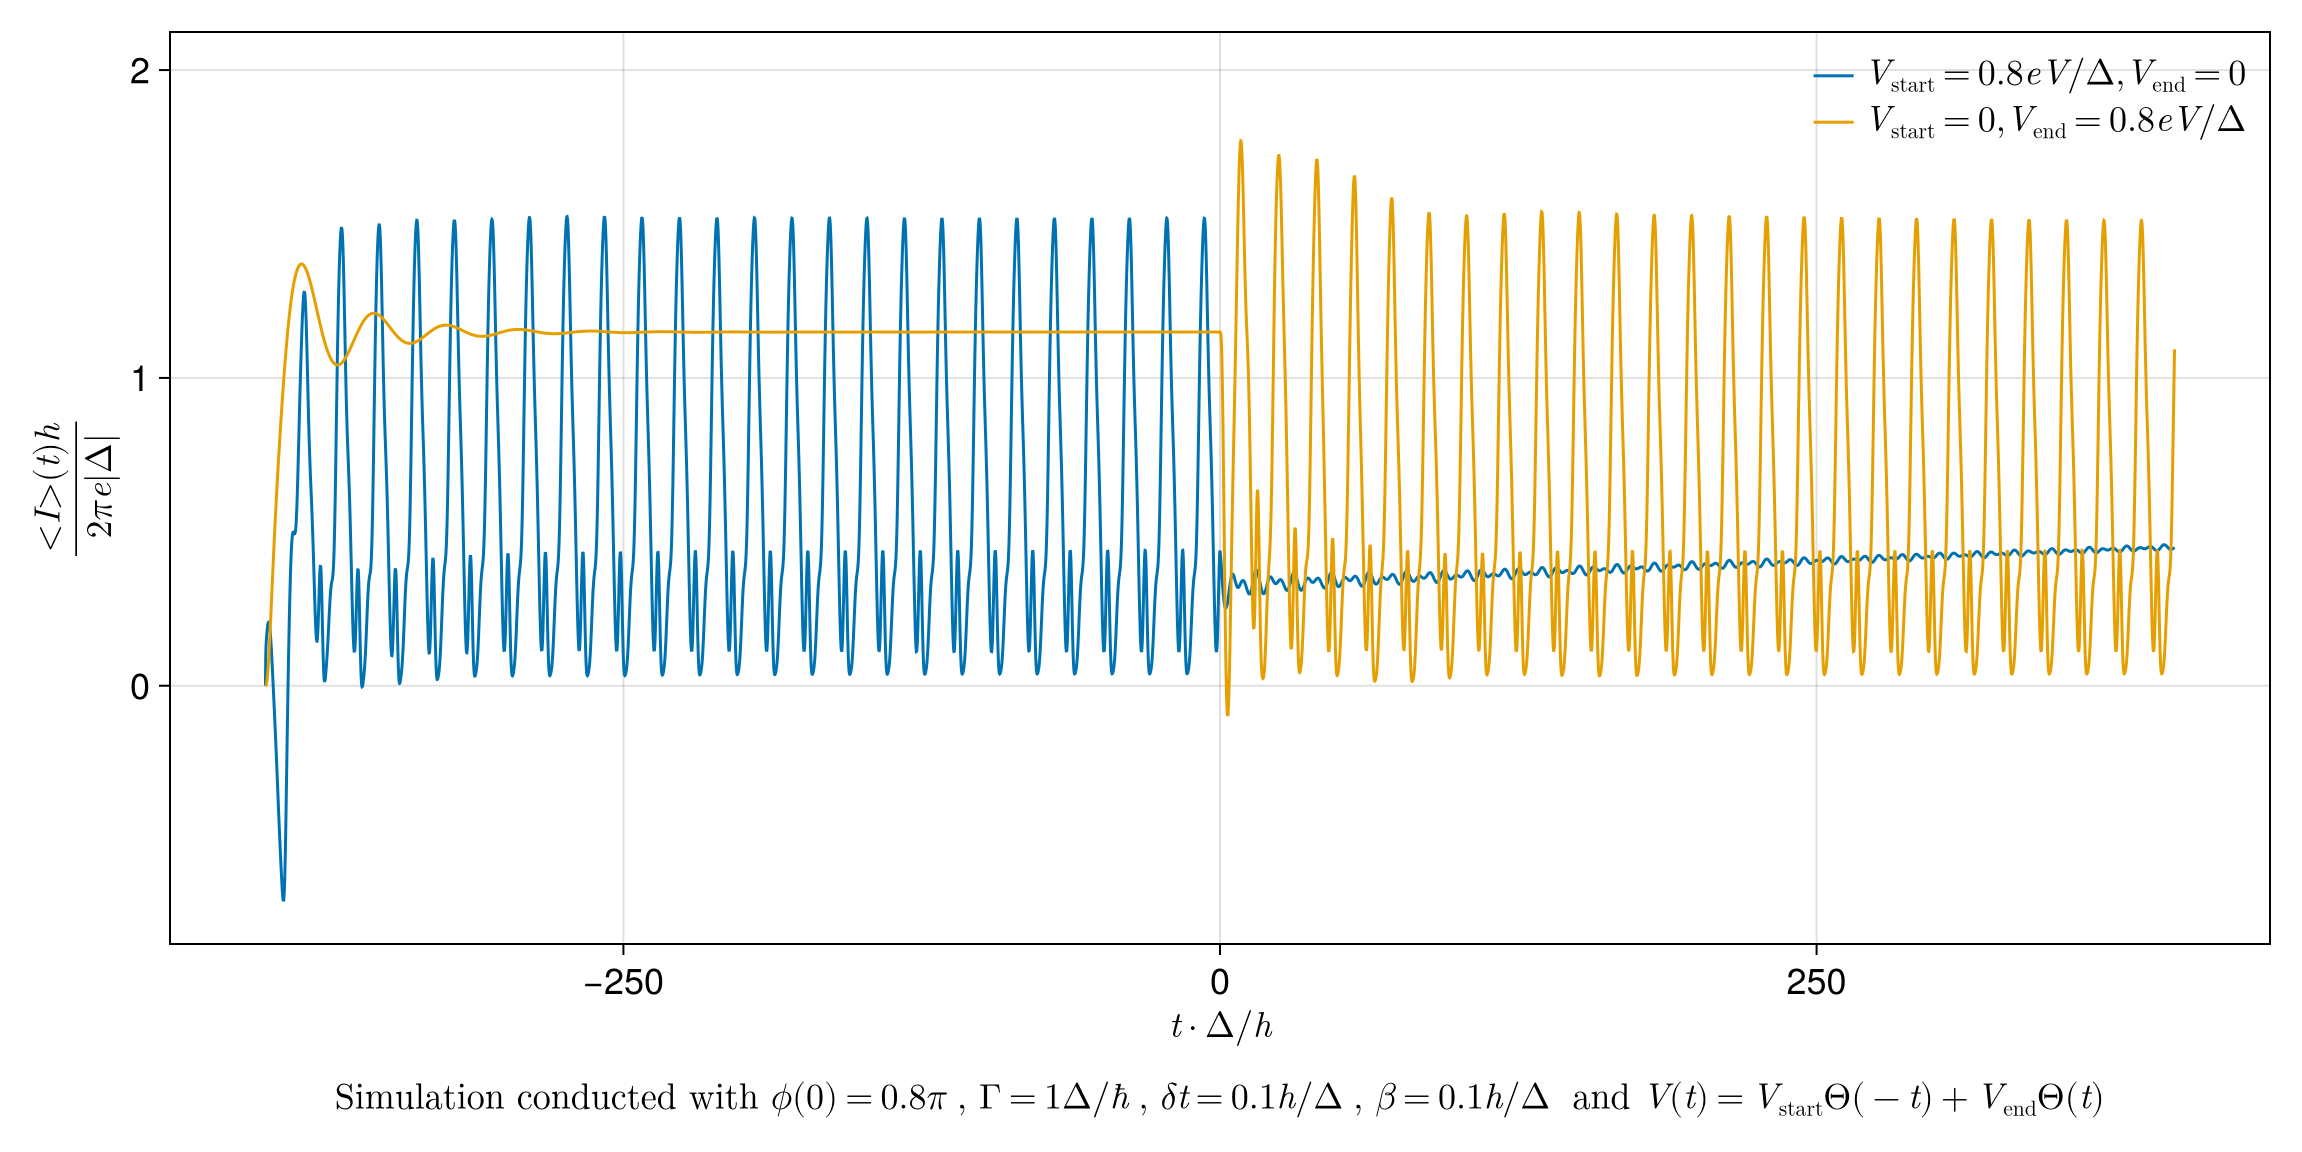

In [10]:
prl_width = 3.38583
size = 170 .* (2 * prl_width, 1 * prl_width)
function add_current(f_ax, I_data, label)
    lines!(f_ax, axis(I_data[:p]) .- I_data[:p].t_start, real.(I_data[:Ij]), label=label)
end
f =  Figure(size=size, fontsize=18)
f_ax = Axis(
    f[1,1], xlabel=L"t \cdot \Delta / h",
    ylabel=L"\frac{< I >(t)h}{2\pi e |\Delta|}"
)
ymax = max(maximum(I_junction_switch_on[:Ij]), maximum(I_junction_switch_off[:Ij]))
ymin = min(minimum(I_junction_switch_on[:Ij]), minimum(I_junction_switch_off[:Ij]))
ylims!(f_ax, 1.2*ymin, 1.2*ymax)
add_current(f_ax, I_junction_switch_off, L"V_\text{start} = %$V eV/\Delta, V_\text{end} = 0")
add_current(f_ax, I_junction_switch_on, L"V_\text{start} = 0, V_\text{end} = %$V eV/\Delta")
axislegend(position=:rt, framevisible=false, labelsize=18)
Label(f[2,1], L"\text{Simulation conducted with } ϕ(0) = %$(ϕ_switch/pi)\pi
 \text{, } \Gamma = %$Γ \Delta / \hbar
 \text{, } \delta t = %$δt h/\Delta
 \text{, } \beta = %$δt h/\Delta
 \text{ and } V(t) = V_\text{start} \Theta(-t) + V_\text{end} \Theta(t)"
 , tellwidth=false, halign=:center)
f

In [11]:
save("../plots/voltage_switching.png", f, pt_per_unit=4)